In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from mvdream.ldm.models.diffusion.ddim import DDIMSampler
from mvdream.model_zoo import build_model
from mvdream.camera_utils import get_camera

%matplotlib inline

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = build_model("sd-v2.1-base-4view")

/home/filip-grigorov/anaconda3/envs/mvdream/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from config: sd-v2-base.yaml
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 20 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280,

In [2]:
print(f"device: \"{DEVICE}\"")

def sample(cond, ucond, steps, shape, scale, ddim_eta):
    images = []
    for i in range(3):
        noise = torch.randn(shape[0], shape[1], shape[2], shape[3], device=DEVICE)  # batch of shape[0]x for 4 views, latent size 32=256/8

        # NOTE: Denoising sampling (e.b., Denoising Diffusion Implicit Models -> DDIM algorithm)
        samples_ddim, _ = sampler.sample(
            S=steps, 
            conditioning=cond,
            batch_size=shape[0], 
            shape=shape[1:],
            verbose=False, 
            unconditional_guidance_scale=scale,
            unconditional_conditioning=ucond,
            eta=ddim_eta, 
            x_T=noise
        )

        x_sample = model.decode_first_stage(samples_ddim)
        x_sample = torch.clamp((x_sample + 1.0) / 2.0, min=0.0, max=1.0)
        x_sample = 255. * x_sample.permute(0, 2, 3, 1).cpu().numpy()
        img = list(x_sample.astype(np.uint8))
        img = np.concatenate(img, 1)
        images.append(img)
    images = np.stack(images)
    return images

seed = 1

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

sampler = DDIMSampler(model)

model.device = DEVICE
model.to(DEVICE)
model.eval()

shape = (4, 4, 32, 32)  # BCHW
scale = 10              # amplifies the difference between conditioned and unconditioned predictions (10 means stricter adherence to conditional guidance)
steps = 20              # number of denoising steps
ddim_eta = 0.0          # controls stochasticity in the DDIM sampling process (controls noise)

with torch.no_grad():
    t = torch.tensor([999] * shape[1], dtype=torch.long, device=DEVICE) # same timestep for 4 views
    txt_prompts = ["flames", "water droplet on surface", "steam from cup of coffee"]
    
    camera = get_camera(shape[1], elevation=15, azimuth_start=90, azimuth_span=360)
    camera = camera.repeat(shape[0] // shape[1], 1)

    ucond = model.get_learned_conditioning([""]).repeat(shape[0], 1, 1).to(DEVICE)
    ucond = {
        "context": ucond,
        "camera": camera.to(DEVICE),
        "num_frames": shape[1]
    }

    scenes = []
    for txt in txt_prompts:
        txt_embedding = model.get_learned_conditioning([txt] * shape[0])
        cond = {
            "context": txt_embedding.to(DEVICE),
            "camera": camera.to(DEVICE),
            "num_frames": shape[1],
        }

        print(f"txt_embedding: {txt_embedding.shape}")
        print(f"camera: {camera.shape}")
        print(f"num_frames: {cond['num_frames']}")

        images = sample(cond, ucond, steps, shape, scale, ddim_eta)

        scenes.append(images)
    

device: "cuda"
txt_embedding: torch.Size([4, 77, 1024])
camera: torch.Size([4, 16])
num_frames: 4


DDIM Sampler: 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


txt_embedding: torch.Size([4, 77, 1024])
camera: torch.Size([4, 16])
num_frames: 4


DDIM Sampler: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


txt_embedding: torch.Size([4, 77, 1024])
camera: torch.Size([4, 16])
num_frames: 4


DDIM Sampler: 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


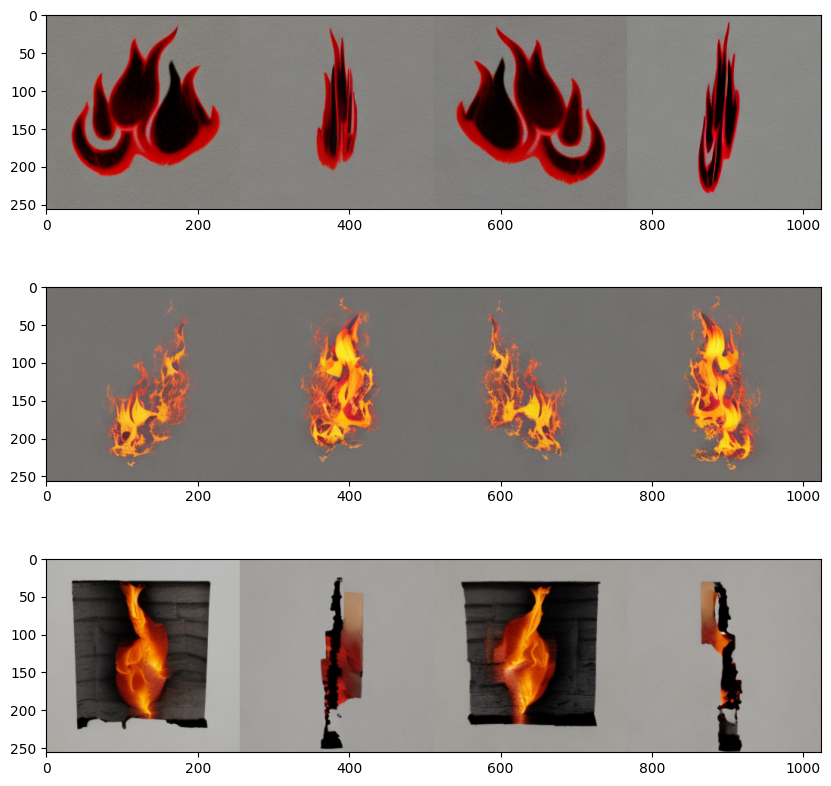

In [3]:
# scene 1
IDX = 0
num_batches = scenes[IDX].shape[0]
fig, axes = plt.subplots(num_batches, 1, figsize=(10, 10))
for i in range(num_batches):
    axes[i].imshow(scenes[IDX][i])

plt.show()

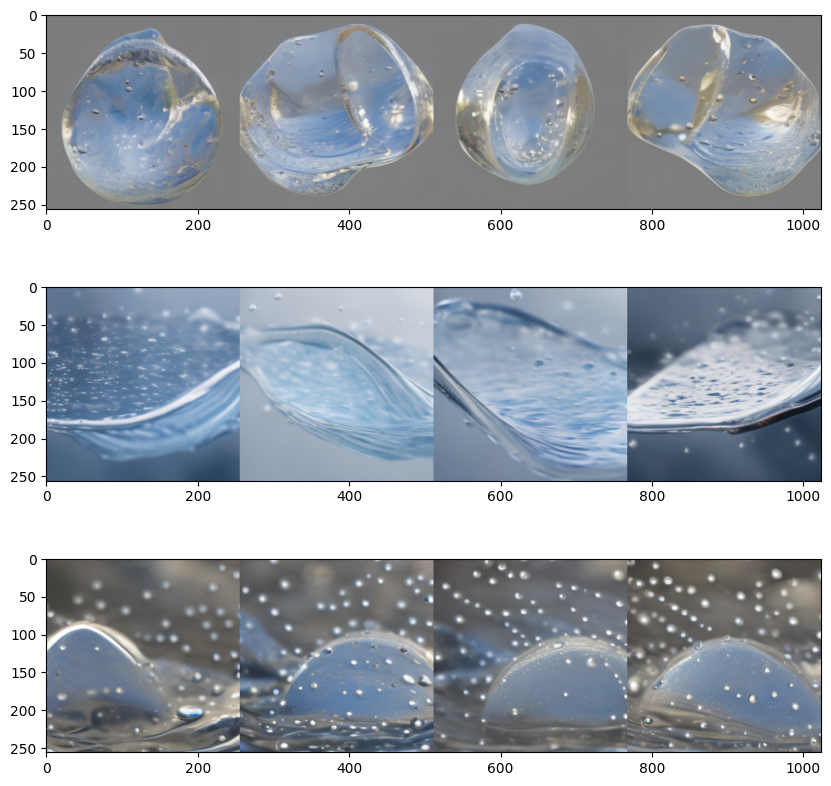

In [4]:
# scene 2
IDX = 1
num_batches = scenes[IDX].shape[0]
fig, axes = plt.subplots(num_batches, 1, figsize=(10, 10))
for i in range(num_batches):
    axes[i].imshow(scenes[IDX][i])

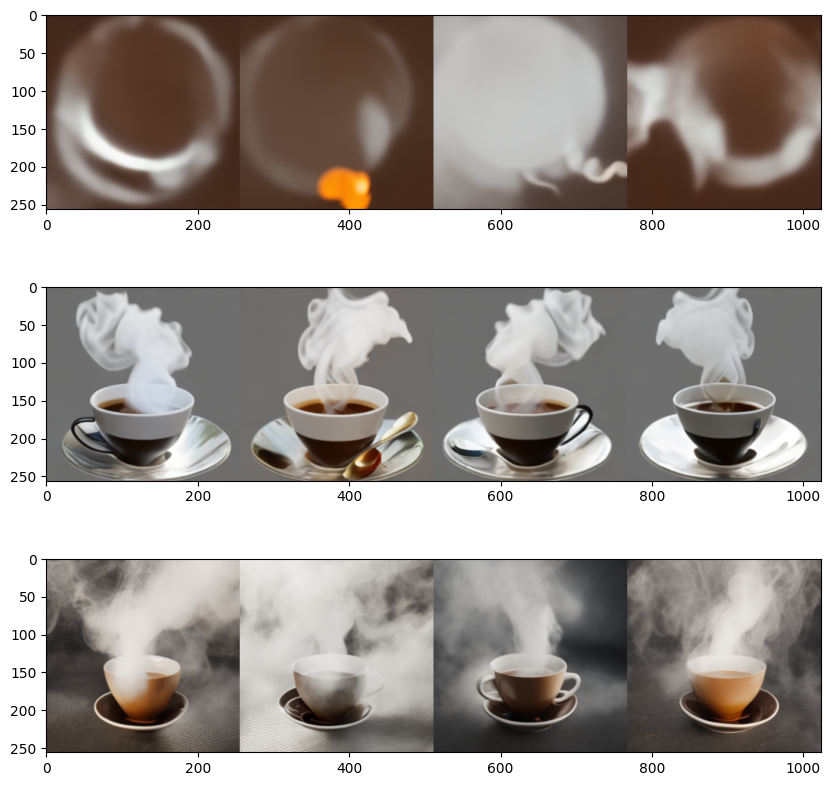

In [5]:
# scene 3
IDX = 2
num_batches = scenes[IDX].shape[0]
fig, axes = plt.subplots(num_batches, 1, figsize=(10, 10))
for i in range(num_batches):
    axes[i].imshow(scenes[IDX][i])